# THIS NOTEBOOK IS OF THE FIRST MODEL:
## model-1

You can download it using following link: https://drive.google.com/drive/folders/1w2P1wKnjrXs57Wzv9Af8BEREdL3eTEui?usp=sharing

### Importing Mordules

In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

import tensorflow as tf
from tensorflow import keras
from keras import layers, Input, Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix



In [15]:
# Make False to disable screen logs 
printLogs = True


def output(text):
    if printLogs:
        print("-"*50)
        print(text)
        print("-"*50)

### Directory Setting

Your Directory structure should look like this:
```shell
mainDIr/
    ├── trainDir/
    │       ├── NORMAL_xray/
    |       |           ├── image1
    |       |           ├── image2
    |       |           └── ...
    |       |
    │       └── PNEUMONIA_xray/
    |                   ├── image1
    |                   ├── image2
    |                   └── ...
    ├── trainDir/
    │       ├── NORMAL_xray/
    |       |           ├── image1
    |       |           ├── image2
    |       |           └── ...
    |       |
    │       └── PNEUMONIA_xray/
    |                   ├── image1
    |                   ├── image2
    |                   └── ...
    └── trainDir/
            ├── NORMAL_xray/
            |           ├── image1
            |           ├── image2
            |           └── ...
            |
            └── PNEUMONIA_xray/
                        ├── image1
                        ├── image2
                        └── ...
    

Keep in mind that names of the folders you can specify below:

In [16]:
# mainDir is the main directory of the dataset

mainDir = "./pneumonia_xray_dataset"

trainDir = os.path.join(mainDir, "train")
testDir = os.path.join(mainDir, "test")
valDir = os.path.join(mainDir, "val")

output(f"Main Dir: \t{mainDir}\nTraining Dir: \t{trainDir}\nTesting Dir: \t{testDir}\nValidation Dir: {valDir}")

--------------------------------------------------
Main Dir: 	./pneumonia_xray_dataset
Training Dir: 	./pneumonia_xray_dataset/train
Testing Dir: 	./pneumonia_xray_dataset/test
Validation Dir: ./pneumonia_xray_dataset/val
--------------------------------------------------


### Data Preprocessing

In [17]:
# You can apply different "Data Augmentation" methods if needed.

train_datagen = ImageDataGenerator(
    rescale= 1./255,
    # rotation_range= 20,
    # width_shift_range= 0.2,
    # height_shift_range= 0.2,
    # zoom_range= 0.2,
    horizontal_flip= True,
)

test_datagen = ImageDataGenerator(
    rescale= 1./255
)

val_datagen = ImageDataGenerator(
    rescale= 1./255
)

### Building a Dataset 

In [18]:
image_size = (300, 400)
batch_size = 16



train_dataset = train_datagen.flow_from_directory(
    directory= trainDir,
    target_size= image_size,
    color_mode= "grayscale",
    batch_size= batch_size,
    class_mode= "sparse",
    shuffle= True,
    seed= 42,
    interpolation= "lanczos",
    
)

test_dataset = test_datagen.flow_from_directory(
    directory= testDir,
    target_size= image_size,
    color_mode= "grayscale",
    batch_size= batch_size,
    class_mode= "sparse",
    shuffle= False,
    interpolation= "lanczos",

)

val_dataset = val_datagen.flow_from_directory(
    directory= valDir,
    target_size= image_size,
    color_mode= "grayscale",
    batch_size= batch_size,
    class_mode= "sparse",
    shuffle= True,
    seed= 42,
    interpolation= "lanczos",

)


Found 13045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 115 images belonging to 2 classes.


### Visualize a dataset

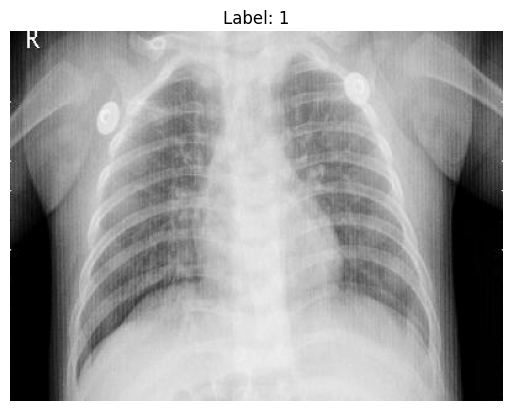

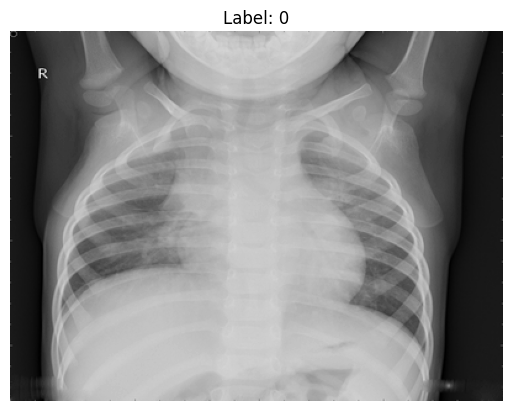

In [ ]:
batch_images, batch_labels = next(val_dataset)

for idx in range(2):
    image = batch_images[idx]
    label = batch_labels[idx]
    plt.figure()
    plt.imshow(image, cmap="gray"),
    plt.title(f"Label: {int(label)}")
    plt.axis("off")
    plt.show()

### Model Architecture

In [7]:
model = Sequential([
    Input(shape= train_dataset.image_shape, batch_size= batch_size),
    
    Conv2D(filters= 32, kernel_size= 3, activation= "relu"),
    MaxPool2D(pool_size= 2, strides= 2),
    
    Conv2D(filters= 64, kernel_size= 3, activation= "relu"),
    MaxPool2D(pool_size= 2, strides= 2),
    
    Conv2D(filters= 128, kernel_size= 5, activation= "relu"),
    MaxPool2D(pool_size= 2, strides= 2),
    
    Conv2D(filters= 256, kernel_size= 7, activation= "relu"),
    MaxPool2D(pool_size= 2, strides= 2),
    
    Conv2D(filters= 512, kernel_size= 9, activation= "relu"),
    MaxPool2D(pool_size= 2, strides= 2),
    
    Flatten(),
    Dense(512, activation= "relu"),

    Dense(2, activation= "softmax")
    
    
    
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (16, 298, 398, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 149, 199, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 147, 197, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 73, 98, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (16, 69, 94, 128)         204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (16, 34, 47, 128)        0

### Compile the Model

In [8]:
model.compile(
    optimizer=  keras.optimizers.Adam(),
    loss=       keras.losses.SparseCategoricalCrossentropy(),
    metrics=    ["accuracy"]
)

output(f"Optimizer: \t{model.optimizer.name}\nLoss Function: \t{model.loss.name}")

--------------------------------------------------
Optimizer: 	Adam
Loss Function: 	sparse_categorical_crossentropy
--------------------------------------------------


### Train the Model

In [9]:
epochs = 10


early_stop = EarlyStopping(
    monitor= "val_loss",
    min_delta= 0.1,
    patience= 3,
    verbose= 1,
    mode= "min",
    restore_best_weights= True,
)


history = model.fit(
    train_dataset,
    validation_data= val_dataset,
    epochs= epochs,
    batch_size= batch_size,
    callbacks= [early_stop]
)

Epoch 1/10
816/816 [==============================] - 3955s 5s/step - loss: 0.4580 - accuracy: 0.8046 - val_loss: 0.3141 - val_accuracy: 0.8609
Epoch 2/10
816/816 [==============================] - 4313s 5s/step - loss: 0.1834 - accuracy: 0.9290 - val_loss: 0.1137 - val_accuracy: 0.9304
Epoch 3/10
816/816 [==============================] - 4386s 5s/step - loss: 0.0972 - accuracy: 0.9673 - val_loss: 0.1328 - val_accuracy: 0.9565
Epoch 4/10
816/816 [==============================] - 3882s 5s/step - loss: 0.0781 - accuracy: 0.9732 - val_loss: 0.0638 - val_accuracy: 0.9739
Epoch 5/10
816/816 [==============================] - 3874s 5s/step - loss: 0.0604 - accuracy: 0.9785 - val_loss: 0.0448 - val_accuracy: 0.9913
Epoch 5: early stopping


### Visualize parameters of Model

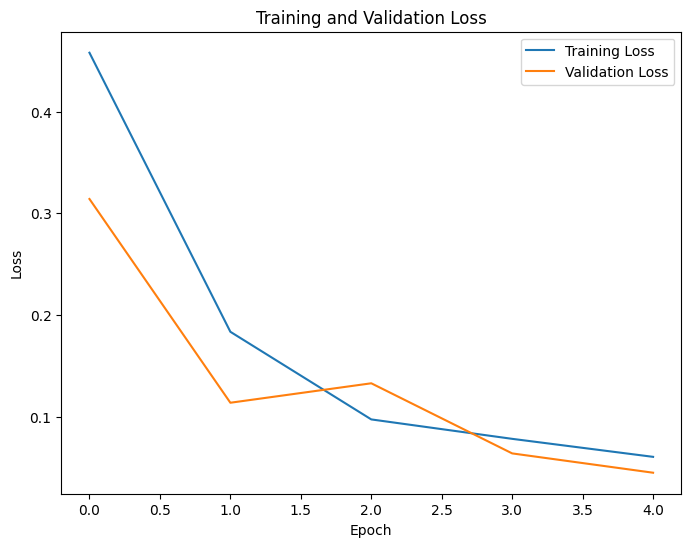

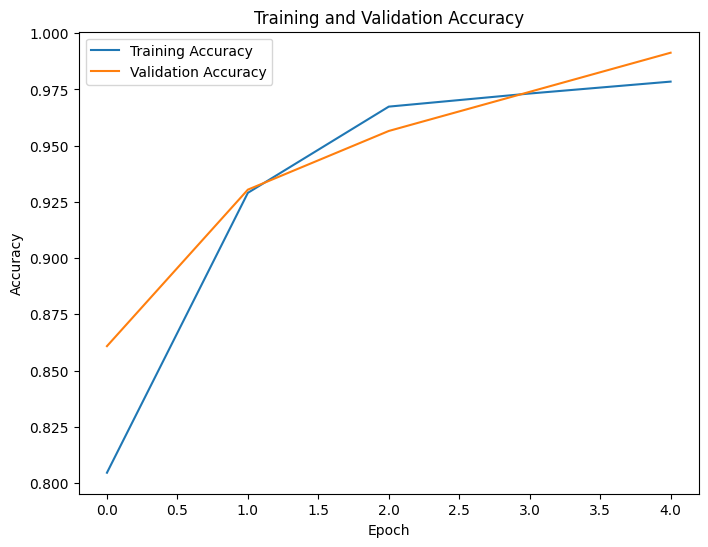

In [10]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


### Save the Model

In [9]:
model_file = "model-1"
# keras.models.save_model(model, model_file)

### Load the model

In [10]:
model = keras.models.load_model(model_file)

### Check the performance on Training data

In [30]:
train_loss, train_accuracy = model.evaluate(train_dataset)

output(f"Train loss: \t{round(train_loss, 2)}\nTrain Accuracy: {round(train_accuracy, 2)}")

--------------------------------------------------
Train loss: 	0.13
Train Accuracy: 0.96
--------------------------------------------------


### Check the performance on Test data

In [13]:
test_loss, test_accuracy = model.evaluate(test_dataset)


output(f"Test loss: \t{round(test_loss, 2)}\nTest Accuracy: \t{round(test_accuracy, 2)}")

39/39 [==============================] - 53s 1s/step - loss: 0.7432 - accuracy: 0.8045
--------------------------------------------------
Test loss: 	0.74
Test Accuracy: 	0.8
--------------------------------------------------


### Check the performance on Validation data


In [14]:
val_loss, val_accuracy = model.evaluate(train_dataset)


output(f"Validation loss: \t{round(val_loss, 2)}\nValidation Accuracy: \t{round(val_accuracy, 2)}")

816/816 [==============================] - 1046s 1s/step - loss: 0.1339 - accuracy: 0.9529
--------------------------------------------------
Validation loss: 	0.13
Validation Accuracy: 	0.95
--------------------------------------------------


### Visualize Testing performance

In [19]:
x = np.arange(len(test_dataset.classes))
y_real = test_dataset.classes
y_pred = np.argmax(model.predict(test_dataset), axis=1)

39/39 [==============================] - 77s 2s/step


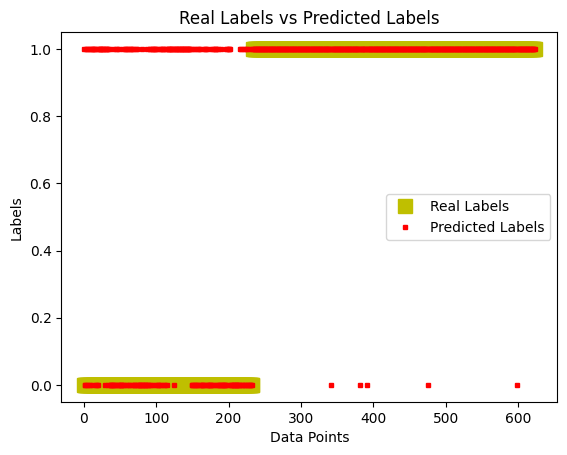

In [27]:
plt.plot(x, y_real, "ys", label= "Real Labels", markersize=10)
plt.plot(x, y_pred, "rs", label= "Predicted Labels", markersize=3)
plt.legend()

plt.xlabel("Data Points")
plt.ylabel("Labels")
plt.title("Real Labels vs Predicted Labels")
plt.show()

### Building a Confusion Matrix

In [22]:
cm = confusion_matrix(y_real, y_pred)
output(cm)

--------------------------------------------------
[[117 117]
 [  5 385]]
--------------------------------------------------


### Visualize a Confusion Matrix

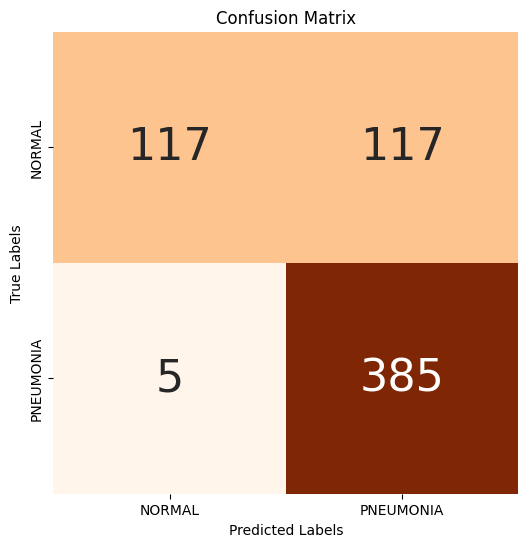

In [47]:

class_names = ["NORMAL", "PNEUMONIA"]
fontsize = 32

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size":fontsize})

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()